# Fair Value Gap - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from candlestick import WHITE_CS, BLACK_CS, DOJI_CS

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
def fvg_modeling(htd):
    """ fair_value_gap """
    data = htd.copy()
    data["oc_dif"] = data.apply(lambda r: r['Close'] - r['Open'], axis=1)
    data['color'] = data.apply(
        lambda r: DOJI_CS if r['oc_dif'] == 0 else (
            WHITE_CS if r['oc_dif'] > 0 else BLACK_CS), axis=1)
    data['color_prev_1'] = data['color'].shift(1)
    data['color_prev_2'] = data['color'].shift(2)
    data['high_prev_2'] = data['High'].shift(2)
    data['low_prev_2'] = data['Low'].shift(2)
    data.dropna(inplace=True)
    data['fvg'] = data.apply(lambda r: cal_fvg(r), axis=1)
    data.drop(columns=['color', 'color_prev_1', 'color_prev_2', 'high_prev_2', 'low_prev_2', 'oc_dif'], inplace=True)
    return data

In [5]:
def cal_fvg(r):
    fvg = ''
    if (r['color_prev_2'] == DOJI_CS or r['color_prev_2'] == BLACK_CS) \
            and r['color_prev_1'] == WHITE_CS and r['color'] == WHITE_CS \
            and r['high_prev_2'] < r['Low'] - 0.1:
        fvg = 'fvg_up'
    elif (r['color_prev_2'] == DOJI_CS or r['color_prev_2'] == WHITE_CS) \
            and r['color_prev_1'] == BLACK_CS and r['color'] == BLACK_CS \
            and r['low_prev_2'] > r['High'] + 0.1:
        fvg = 'fvg_down'
    return fvg

In [6]:
data = fvg_modeling(data)

In [7]:
data['min_3_low'] = data['Low'].rolling(3).min()
data['max_3_high'] = data['High'].rolling(3).max()

In [8]:
data.dropna(inplace=True)

In [9]:
data

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high
Date,,,,,,,,
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,,942.3,943.7
2018-08-13 09:25:00,943.8,945.9,943.7,945.3,2469,fvg_up,942.3,945.9
2018-08-13 09:30:00,945.2,945.5,943.9,944.0,1668,,942.4,945.9
2018-08-13 09:35:00,944.0,944.5,943.7,943.7,1543,,943.7,945.9
2018-08-13 09:40:00,943.8,944.8,943.3,944.5,1722,,943.3,945.5
...,...,...,...,...,...,...,...,...
2024-09-18 14:15:00,1310.7,1313.5,1308.7,1312.8,8783,,1308.7,1313.5
2024-09-18 14:20:00,1312.8,1313.2,1310.8,1311.3,6209,,1308.7,1313.5
2024-09-18 14:25:00,1311.1,1313.3,1311.1,1311.2,5452,,1308.7,1313.5


### Calculating return

In [10]:
RR = 3
def cal_return(data):
    data['return'] = ''
    data['exit_time'] = ''
    data['entry_price'] = ''
    data['exit_price'] = ''
    data['deal_type'] = ''
    data['sl_length'] = ''
    data['min_max_length'] = ''
    for i, row in data.iterrows():
        if 910 < 100*row.name.hour + row.name.minute < 1430:
            if row['fvg'] != '':
                _return = 0
                current_date = row.name.strftime('%Y-%m-%d ').format()
                current_time = row.name
                entry_price = max_price = min_price = row['Close']
                data_from_start_day = data[(data.index < current_time) & (data.index > current_date + ' 08:59:00')]
                if 100*row.name.hour + row.name.minute < 1405:
                    if row['fvg'] == 'fvg_up':
                        deal_type = 'long'
                        stoploss = row['min_3_low']
                        sl_length = entry_price - stoploss
                        min_max_length = entry_price - data_from_start_day['Low'].min()
                    else:
                        deal_type = 'short'
                        stoploss = row['max_3_high']
                        sl_length = stoploss - entry_price
                        min_max_length = data_from_start_day['High'].max() - entry_price
                exit_time = ''
                exit_price = 0
                data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
                for k, wrow in data_to_end_day.iterrows():
                    if deal_type == 'long':
                        if wrow['Low'] < stoploss:
                            # if max_price >= entry_price + RR * sl_length:
                            #     # Take profit
                            #     _return = RR * sl_length
                            #     exit_time = wrow.name
                            #     exit_price = entry_price + RR * sl_length
                            # else:
                                # Stoploss
                            if max_price < entry_price + sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = stoploss - entry_price
                                exit_time = wrow.name
                                exit_price = wrow['Low']
                            else:
                                _return = max_price - entry_price
                            break
                        else:
                            if wrow['High'] > max_price:
                                max_price = wrow['High']
                                exit_time  = wrow.name
                                exit_price = max_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = max_price - entry_price
                                break
                    if deal_type == 'short':
                        if wrow['High'] > stoploss:
                            if min_price > entry_price - sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = entry_price - stoploss
                                exit_time = wrow.name
                                exit_price = stoploss
                            else:
                                _return = entry_price - min_price
                            break
                        else:
                            if wrow['Low'] < min_price:
                                min_price = wrow['Low']
                                exit_time  = wrow.name
                                exit_price = min_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = entry_price - min_price
                                break
                data.at[i, 'deal_type'] = deal_type
                data.at[i, 'entry_price'] = entry_price
                data.at[i, 'return'] = _return
                data.at[i, 'exit_price'] = exit_price
                data.at[i, 'exit_time'] = exit_time
                data.at[i, 'sl_length'] = sl_length
                data.at[i, 'min_max_length'] = min_max_length
    return data

In [11]:
data = cal_return(data)

In [12]:
has_return = data[(data['return'] != '') & (data['return'] != 0)]

In [13]:
has_return

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,
2018-08-13 10:25:00,944.0,944.2,943.5,943.9,1538,fvg_down,943.5,945.7,-1.8,2018-08-13 11:10:00,943.9,945.7,short,1.8,2.5
2018-08-14 11:10:00,952.9,953.3,952.1,952.3,1416,fvg_down,952.1,954.4,-2.1,2018-08-14 11:25:00,952.3,954.4,short,2.1,5.0
2018-08-16 10:20:00,941.7,941.8,940.7,940.8,1409,fvg_down,940.7,943.5,5.3,2018-08-16 11:15:00,940.8,935.5,short,2.7,2.7
2018-08-17 10:30:00,952.5,952.7,951.7,951.9,1235,fvg_down,951.7,953.7,3.4,2018-08-17 10:55:00,951.9,948.5,short,1.8,1.8
2018-08-20 09:35:00,945.1,945.1,944.1,944.5,2314,fvg_down,944.1,947.0,-2.5,2018-08-20 10:10:00,944.5,947.0,short,2.5,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16 09:25:00,1294.0,1294.3,1293.0,1293.7,3180,fvg_down,1293.0,1295.8,-2.1,2024-09-16 09:35:00,1293.7,1295.8,short,2.1,3.3
2024-09-16 09:35:00,1295.3,1295.9,1295.2,1295.6,3277,fvg_up,1293.0,1295.9,-2.6,2024-09-16 11:25:00,1295.6,1291.4,long,2.6,2.6
2024-09-16 10:10:00,1296.3,1296.7,1296.2,1296.6,1558,fvg_up,1295.4,1297.4,-1.2,2024-09-16 10:20:00,1296.6,1294.7,long,1.2,3.6


In [14]:
has_return['return'].sum()

-1367.3000000000095

In [15]:
long = has_return[has_return['deal_type'] == 'long']

In [16]:
long.tail(30)

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,
2024-07-16 10:05:00,1303.3,1305.4,1303.1,1305.4,8203,fvg_up,1301.5,1305.4,-3.9,2024-07-16 14:10:00,1305.4,1300.1,long,3.9,5.1
2024-07-17 13:30:00,1306.5,1309.5,1306.5,1308.4,13328,fvg_up,1302.1,1309.5,13.4,2024-07-17 14:05:00,1308.4,1321.8,long,6.3,6.7
2024-07-17 14:05:00,1318.2,1321.8,1318.2,1318.5,11654,fvg_up,1312.5,1321.8,-16.4,2024-07-17 14:20:00,1318.5,1294.7,long,6.3,6.7
2024-07-23 10:45:00,1300.1,1300.7,1299.9,1300.2,1510,fvg_up,1298.6,1300.7,2.2,2024-07-23 11:25:00,1300.2,1302.4,long,1.6,1.6
2024-07-26 13:05:00,1278.8,1279.4,1278.8,1279.0,1624,fvg_up,1278.2,1279.4,2.1,2024-07-26 13:20:00,1279.0,1281.1,long,0.8,2.2
2024-07-29 13:10:00,1291.7,1292.1,1291.7,1291.9,2055,fvg_up,1290.9,1292.1,-1.0,2024-07-29 13:20:00,1291.9,1290.5,long,1.0,2.0
2024-07-30 11:20:00,1287.2,1288.8,1287.2,1288.8,3974,fvg_up,1286.5,1288.8,3.6,2024-07-30 13:20:00,1288.8,1292.4,long,2.3,4.6
2024-07-31 11:25:00,1299.9,1301.2,1299.7,1301.1,3848,fvg_up,1298.9,1301.2,-2.2,2024-07-31 13:50:00,1301.1,1298.6,long,2.2,10.0
2024-08-02 10:15:00,1266.0,1266.7,1265.9,1266.2,3378,fvg_up,1264.8,1266.7,-1.4,2024-08-02 10:35:00,1266.2,1264.7,long,1.4,3.9


In [17]:
long['sl_length'] = long['sl_length'].astype(float)

In [18]:
long['sl_group'] = pd.qcut(long.sl_length, 20)

In [19]:
long['min_max_length'] = long['min_max_length'].astype(float)

In [20]:
long['return'] = long['return'].astype(float)

In [21]:
long['min_max_group'] = pd.qcut(long.min_max_length, 20)

In [22]:
long['sl_length'].describe()

count    1003.000000
mean        3.454835
std         2.517540
min         0.500000
25%         1.800000
50%         2.800000
75%         4.300000
max        23.000000
Name: sl_length, dtype: float64

In [23]:
long['return'].describe()

count    1003.000000
mean       -0.968195
std         5.888418
min       -23.000000
25%        -3.700000
50%        -2.100000
75%         1.750000
max        67.300000
Name: return, dtype: float64

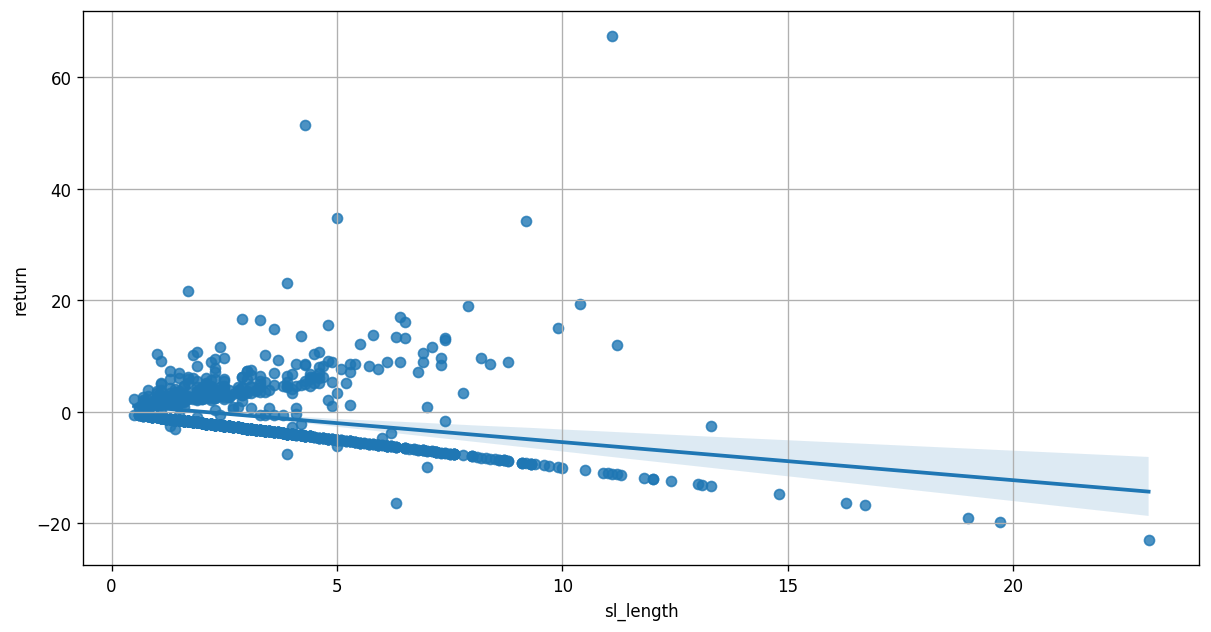

In [24]:
sns.regplot(x=long['sl_length'], y=long['return'])
plt.grid(True)

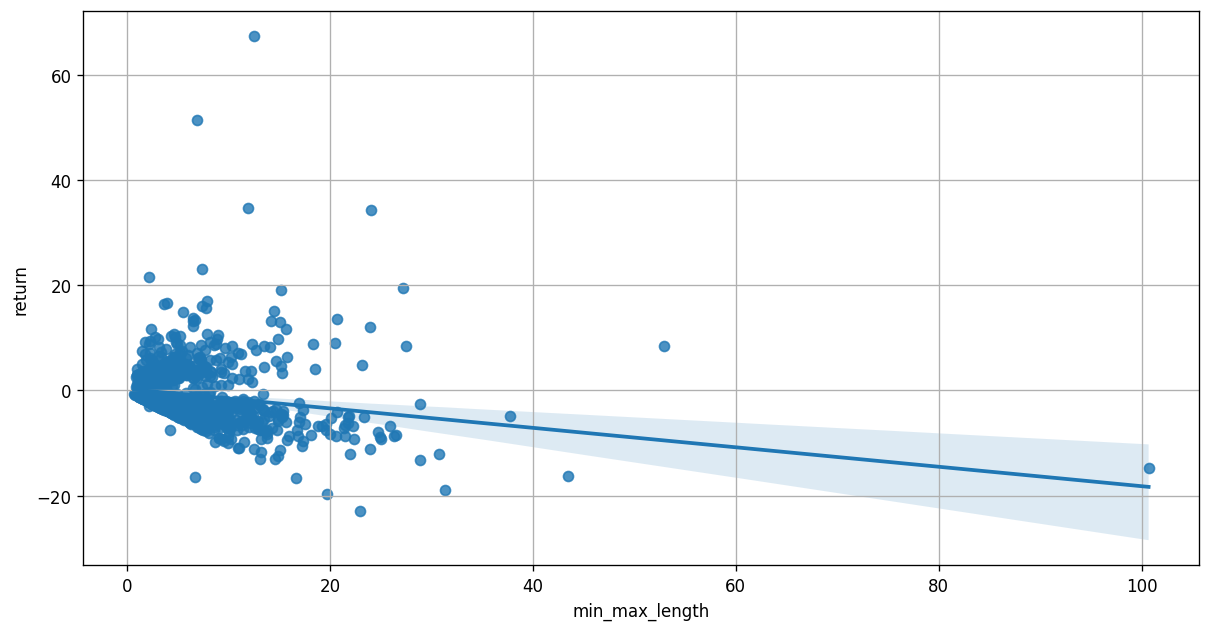

In [25]:
sns.regplot(x=long['min_max_length'], y=long['return'])
plt.grid(True)

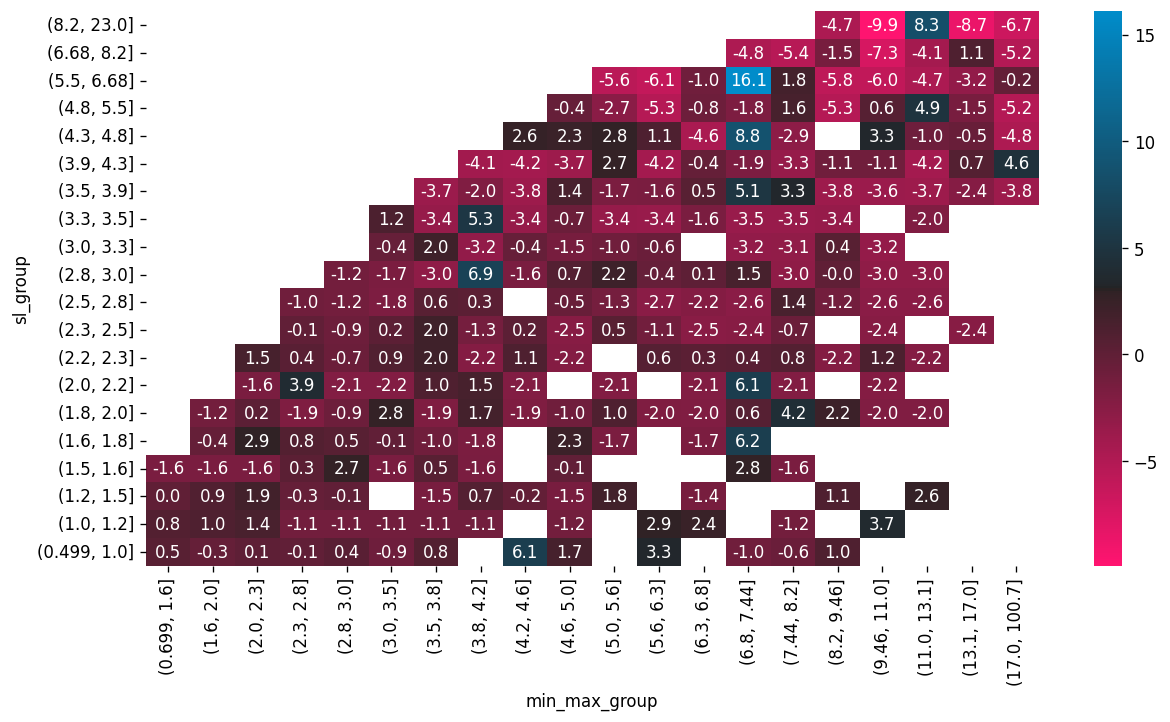

In [26]:
grpd = long.groupby(['sl_group', 'min_max_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='sl_group', columns='min_max_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");